# Interpolating Missing Values in Raster Time Series with Geowombat and XR_Fresh
This notebook demonstrates how to:
1. Load raster time series with missing values (`NaN`).
2. Interpolate missing data using the `xr_fresh` library.
3. Save and visualize the interpolated results.

We will use **geowombat** to handle raster files and **xr_fresh** for interpolation.

## Step 1: Install Required Libraries
Ensure you have the necessary libraries installed. Run the following command in your terminal or notebook:

```bash
conda install -y -c conda-forge geowombat-ml ray-default
git clone https://github.com/mmann1123/xr_fresh
cd xr_fresh
pip install -U pip setuptools wheel
pip install . 
```

## Step 2: Prepare Input Raster Files
We have a series of `.tif` files named in the `/xr_fresh/tests/data` directory. These files represent time steps with missing values (`NaN`).:

```
data/values_equal_1.tif
data/values_equal_2.tif
data/values_equal_3.tif
data/values_equal_4.tif
data/values_equal_5.tif
```

These files represent time steps with missing values (`NaN`).

## Step 3: Load the Raster Time Series
We will use **geowombat** to open the raster time series.

/home/mmann1123/miniconda3/envs/xr_fresh_update/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Raster files: ['values_equal_1.tif', 'values_equal_2.tif', 'values_equal_3.tif', 'values_equal_4.tif', 'values_equal_5.tif']


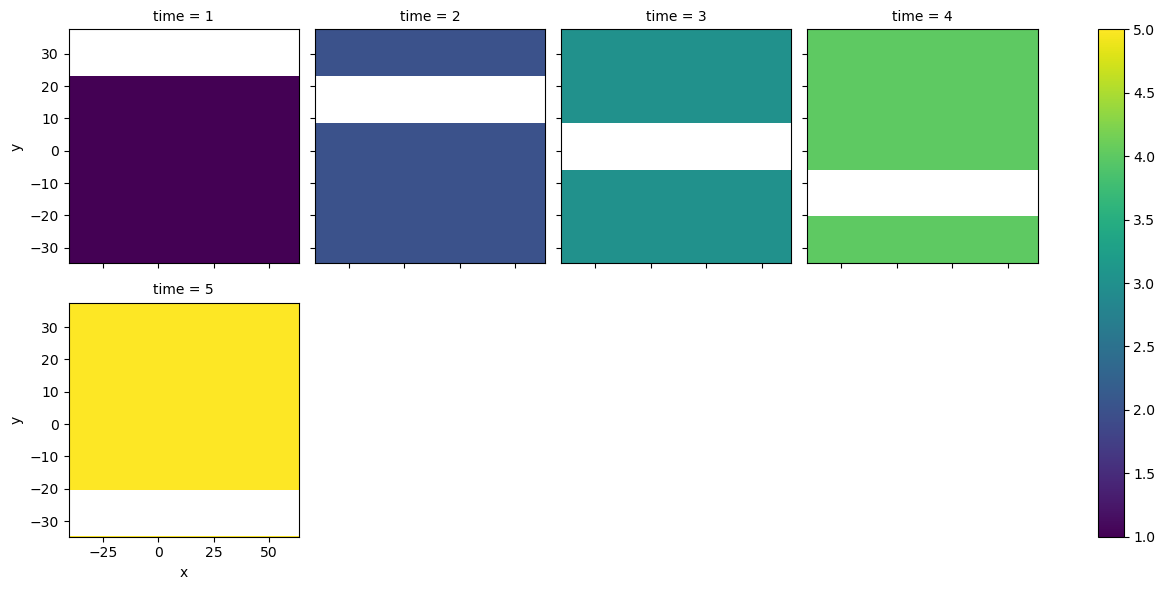

In [1]:
import geowombat as gw
import matplotlib.pyplot as plt
from pathlib import Path 
import os
from glob import glob

# Define the directory containing raster files
os.chdir("../../tests/data/")

files = sorted(glob("values_equal_*.tif"))
# Print file paths for debugging
print("Raster files:", files)

with gw.open(files) as ds:
    ds.plot(col="time", col_wrap=4, cmap="viridis", robust=True)

Notice that each image holds a fixed value ranging from 1 to 5. We then have alternating `NaN` values in the time series.

## Step 4: Perform Interpolation with XR_Fresh
We will use the `interpolate_nan` function from **xr_fresh** to fill the missing data.

In [2]:
from xr_fresh.interpolate_series import interpolate_nan
import numpy as np
import tempfile
temp_dir = tempfile.mkdtemp()

# Output path for the interpolated raster
output_file = os.path.join(temp_dir,"interpolated_time_series.tif")

# Apply interpolation
with gw.series(files, transfer_lib="jax", window_size=[256, 256]) as src:
    src.apply(
        func=interpolate_nan(
            interp_type="linear",   # Interpolation type
            missing_value=np.nan,   # Value representing missing data
            count=len(src.filenames)  # Number of time steps
        ),
        outfile=output_file,
        bands=1,  # Apply interpolation to the first band
    )

print("Interpolation completed. Output saved to:", output_file)

2025-05-21 15:43:27.274100: W external/xla/xla/service/platform_util.cc:198] unable to create StreamExecutor for CUDA:0: failed initializing StreamExecutor for CUDA device ordinal 0: INTERNAL: failed call to cuDevicePrimaryCtxRetain: CUDA_ERROR_OUT_OF_MEMORY: out of memory; total memory reported: 12516655104
CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 70/70 [00:18<00:00,  3.83it/s]


Interpolation completed. Output saved to: /tmp/tmpfltrq8w8/interpolated_time_series.tif


**Note:** If you have a GPU or limited RAM you can adjust the amount of memory used by setting the `window_size` parameter, just make sure the window dims are multiple of 16.

## Step 5: Visualize the Results
Visualize the original and interpolated bands to confirm that `NaN` values have been filled.

Raster files: ['values_equal_1.tif', 'values_equal_2.tif', 'values_equal_3.tif', 'values_equal_4.tif', 'values_equal_5.tif']


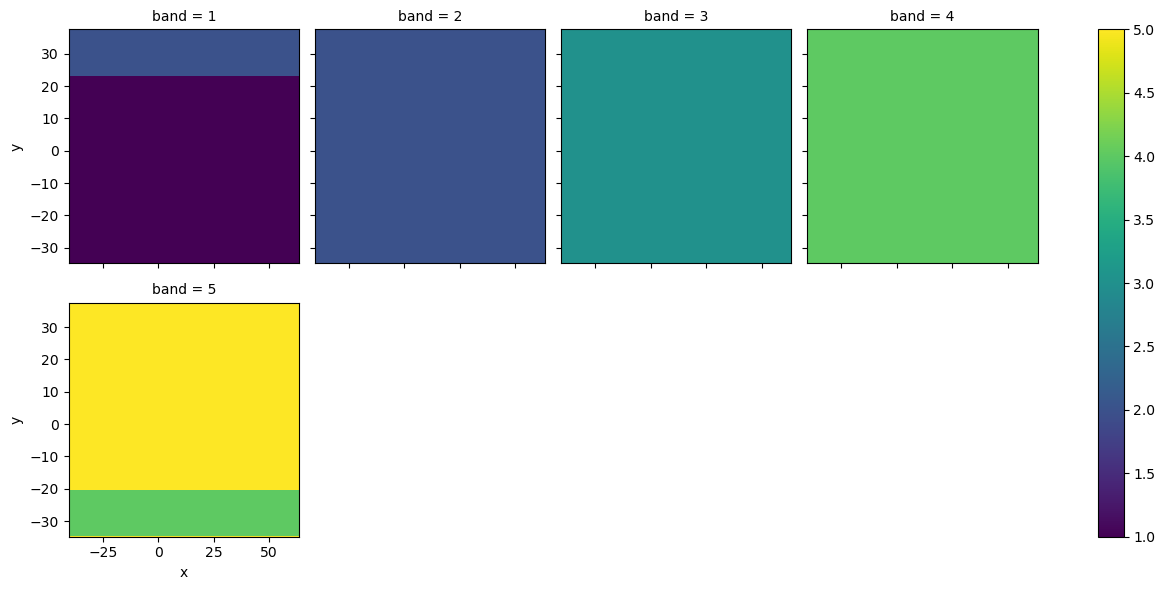

In [3]:
# Define the directory containing raster files
interpolated_file = Path(temp_dir, "interpolated_time_series.tif")

# Print file paths for debugging
print("Raster files:", files)

with gw.open(interpolated_file) as ds:
    # display(ds)
    ds.plot(col="band", col_wrap=4, cmap="viridis", robust=True)

Next let's look at a plot of the original and interpolated bands. Here we use a random sample of cells (n controlled by `samples`) to show the difference between the original and interpolated values.

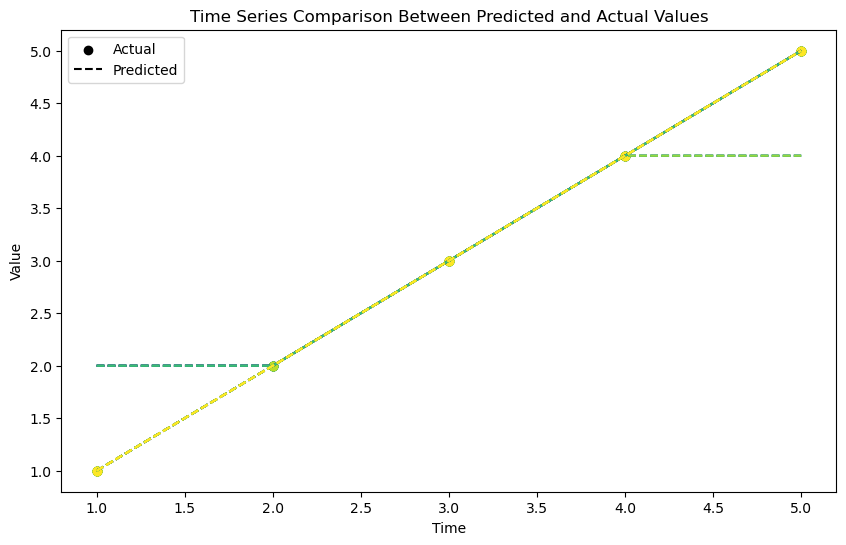

In [4]:
from xr_fresh.visualizer import plot_interpolated_actual

# Plot the interpolated and actual time series
plot_interpolated_actual(interpolated_stack=interpolated_file,
                         original_image_list=files,
                        samples=2 )

Notice that the initial and final periods are not interpolated correctly, this is a limitation of the method used.

## Summary
In this notebook, you:
1. Loaded a raster time series with missing values using **geowombat**.
2. Interpolated the missing values using **xr_fresh**.
3. Visualized and validated the interpolated output.

This workflow is useful for cleaning raster datasets for time series analysis.

## Practical Example

This workflow can be used to interpolate missing values in any gridded dataset, such as satellite imagery, weather data, or any other raster dataset with missing values.

In this case we will take a short series of measurements of average temperature in a region and interpolate the missing values.

In [5]:
import pandas as pd
from datetime import datetime

file_glob = f"RadT_*tif"
strp_glob = f"RadT_tavg_%Y%m.tif"

dates = sorted(
    datetime.strptime(string, strp_glob) for string in sorted(glob(file_glob))
)
files = sorted(glob(file_glob))

# print dates and files in a table
pd.DataFrame({"date": dates, "file": files})

,date,file
0,2023-01-01,RadT_tavg_202301.tif
1,2023-02-01,RadT_tavg_202302.tif
2,2023-04-01,RadT_tavg_202304.tif
3,2023-05-01,RadT_tavg_202305.tif


Now let's remove some values from the dataset and interpolate them.

In [6]:
# Open the dataset
with gw.open(files) as src:
    for i in range(len(src)):

        # Replace alternating strips of rows with NaN values in each band
        block_length = len(src[0, 0]) // 5  # Divide the y dimension into 5 blocks
        start_row = i * block_length  # Start row index for the current block
        end_row = (i + 1) * block_length  # End row index for the current block

        # Replace the rows in each band with NaN values for the current block
        src[i, :, start_row:end_row, :] = np.nan

        # Save the modified dataset
        gw.save(
            src.sel(time=i + 1), f"{temp_dir}/tavg_nan_{datetime.strftime(dates[i],'%Y%j')}.tif", overwrite=True
        )

100%|██████████| 341/341 [00:00<00:00, 3300.99it/s]


Let's take a look at the new data set with missing values.

Raster files: ['RadT_tavg_202301.tif', 'RadT_tavg_202302.tif', 'RadT_tavg_202304.tif', 'RadT_tavg_202305.tif']


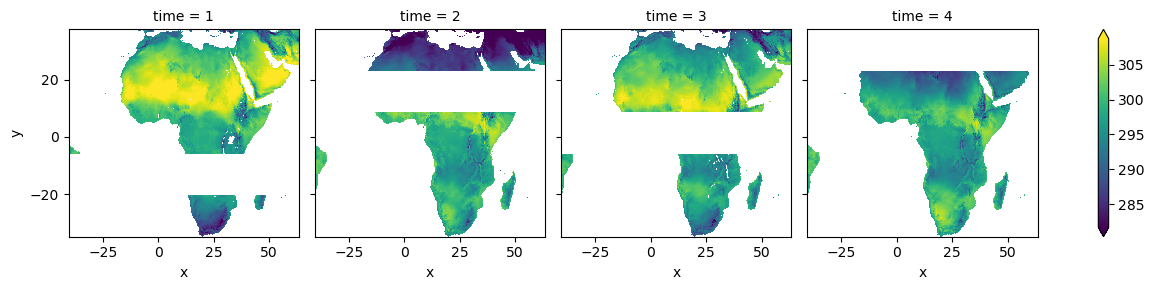

In [7]:
# Define the directory containing raster files
tavg_missing =  glob(os.path.join(temp_dir,"tavg_nan_*.tif"))

# Print file paths for debugging
print("Raster files:", files)

with gw.open(tavg_missing) as ds:
    ds.plot(col="time", col_wrap=4, cmap="viridis", robust=True)

Now let's use the linear interpolation method to fill the missing values.

In [8]:
# Output path for the interpolated raster
output_file = os.path.join(temp_dir, "tavg_interp.tif")

# Apply interpolation
with gw.series(tavg_missing, transfer_lib="jax", window_size=[256, 256]) as src:
    src.apply(
        func=interpolate_nan(
            interp_type="linear",  # Interpolation type
            # dates=dates,  # Dates of the time series
            missing_value=np.nan,  # Value representing missing data
            count=len(src.filenames),  # Number of time steps
        ),
        outfile=output_file,
        bands=1,  # Apply interpolation to the first band
    )

print("Interpolation completed. Output saved to:", output_file)

100%|██████████| 70/70 [00:09<00:00,  7.44it/s]


Interpolation completed. Output saved to: /tmp/tmpfltrq8w8/tavg_interp.tif


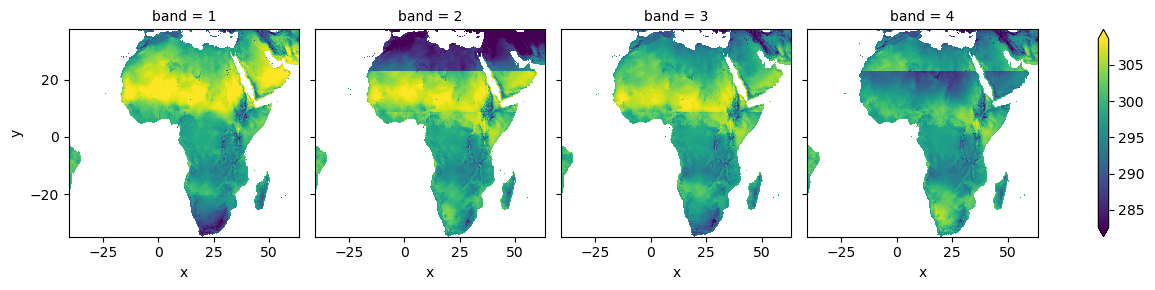

In [9]:
with gw.open(output_file) as ds:
    ds.plot(col="band", col_wrap=4, cmap="viridis", robust=True)

Notice that the output is a stack of images, with each image representing a time step with the missing values filled. Each one is stored as a `band` in the `xarray` object.

In [10]:
display(ds)

<xarray.DataArray (band: 4, y: 1613, x: 2313)>
dask.array<open_rasterio-91f2d08c0e47ae3f29ae912ef9340173<this-array>, shape=(4, 1613, 2313), dtype=float64, chunksize=(4, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * band     (band) int64 1 2 3 4
  * x        (x) float64 -40.36 -40.31 -40.27 -40.22 ... 63.35 63.4 63.44 63.49
  * y        (y) float64 37.57 37.53 37.48 37.44 ... -34.7 -34.74 -34.79 -34.83
Attributes: (12/13)
    transform:           (0.04491576420597607, 0.0, -40.37927202117249, 0.0, ...
    crs:                 4326
    res:                 (0.04491576420597607, 0.04491576420597607)
    is_tiled:            1
    nodatavals:          (0.0, 0.0, 0.0, 0.0)
    _FillValue:          0.0
    ...                  ...
    offsets:             (0.0, 0.0, 0.0, 0.0)
    filename:            /tmp/tmpfltrq8w8/tavg_interp.tif
    resampling:          nearest
    AREA_OR_POINT:       Area
    _data_are_separate:  0
    _data_are_stacked:   0

Let's visualize the results to confirm that the missing values have been filled correctly. 

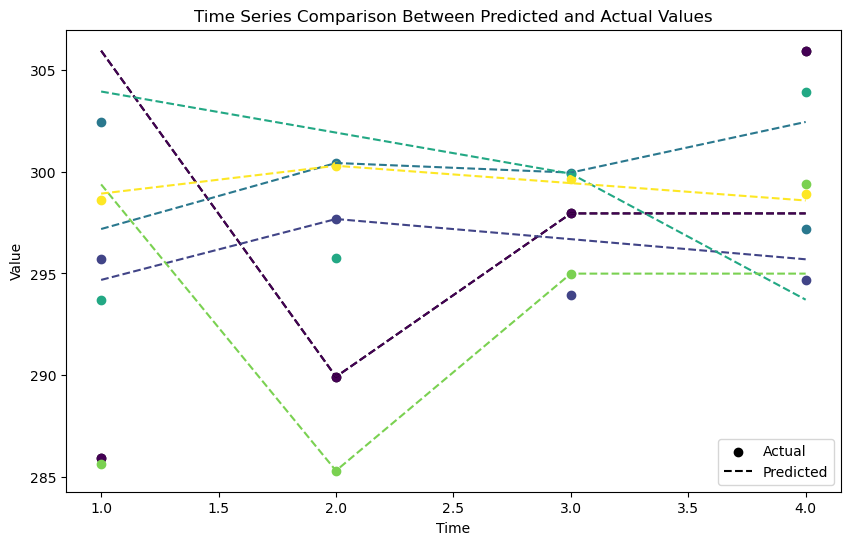

In [11]:
from xr_fresh.visualizer import plot_interpolated_actual

# Plot the interpolated and actual time series
plot_interpolated_actual(
    interpolated_stack=output_file, original_image_list=files, samples=5
)

So finally we need to write each band out to a separate file.

In [12]:
# write out each band as a separate file
with gw.open(output_file) as ds:
    for i in range(len(ds)):
        gw.save(ds[i], f"{temp_dir}/tavg_interp_{datetime.strftime(dates[i],'%Y%j')}.tif", overwrite=True)

100%|██████████| 211/211 [00:00<00:00, 881.52it/s]


Now let's confirm they were written correctly.

In [13]:
glob(os.path.join(temp_dir, "tavg_interp_*.tif"))

['/tmp/tmpfltrq8w8/tavg_interp_2023001.tif',
 '/tmp/tmpfltrq8w8/tavg_interp_2023032.tif',
 '/tmp/tmpfltrq8w8/tavg_interp_2023121.tif',
 '/tmp/tmpfltrq8w8/tavg_interp_2023091.tif']